# Calculate quasi-static error susceptibility
**Characterizing the robustness of a pulse to quasi-static noise**

The Q-CTRL Python package enables you to evaluate the susceptibility of quantum controls to quasi-static noise on multiple simultaneous noise channels. This process can provide a useful characterization of the robustness of candidate controls. In this notebook we show how to compute quasi-static scans using the Q-CTRL Python package.

## Imports and initialization

All usage of the Q-CTRL Python package begins by importing the `qctrl` package and starting a session.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Predefined pulse imports
from qctrlopencontrols import (
    new_bb1_control,
    new_corpse_control,
    new_primitive_control,
    new_sk1_control,
)

from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl()

## Worked example: Susceptibility to simultaneous amplitude and dephasing noise

In this example we will compare a series of composite $\pi$ pulses applied to a single qubit under amplitude and dephasing noise. The Hamiltonian of the quantum system is:

\begin{align*}
H(t) = &\frac{1+\beta_\Omega(t)}{2}\left( \Omega(t) \sigma_- + \Omega^*(t) \sigma_+ \right) + \frac{\Delta(t)}{2}\sigma_z + \frac{\eta(t)}{2} \sigma_z
\end{align*}

where $\Omega(t)$ is a time-dependent Rabi rate, $\beta_\Omega(t)$ is a fractional time-dependent amplitude fluctuation process, $\Delta(t)$ is a time-dependent clock shift, $\eta(t)$ is a small slowly-varying stochastic dephasing noise process, $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$, and $\sigma_k$ are the Pauli matrices.

We consider the following driven control schemes for the controllable $\Omega(t)$ and $\Delta(t)$ terms, which are available from [Q-CTRL Open Controls](https://q-ctrl.com/products/open-controls/) and described in the [reference documentation](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols.html): primitive, BB1, SK1, and CORPSE.

In a 2D quasi-static scan, we scan across a two-dimensional grid of values $(\beta_\Omega,\eta)$ for $\beta_\Omega(t)\equiv \beta_\Omega$ and $\eta(t)\equiv\eta$, and calculate the infidelity of the resulting gate in each case. Comparing the variation in infidelity across the grid gives information about the robustness of the appropriate control to simultaneous quasi-static noise on the two channels.

In this particular system we use a grid with $\beta_\Omega\in [-0.5,0.5]$ and $\eta\in[-\Omega_{\mathrm{max}}, \Omega_{\mathrm{max}}]$ (where $\Omega_{\mathrm{max}}$ is the maximum Rabi rate).

### Creating the controls and pulses

As described in the [Setting up quantum systems](https://docs.q-ctrl.com/boulder-opal/user-guides/setting-up-quantum-systems) user guide, we first set up Python objects representing the pulses and controls.

The [`qctrl.functions.calculate_quasi_static_scan`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_quasi_static_scan.html) function accepts the Hamiltonian in the form of separate terms for each of the complex-valued controls (`drives`), real-valued controls (`shifts`), and static terms (`drifts`).
In the Hamiltonian used in this example, the drive corresponds to the term that contains the Rabi rate ($\Omega(t)$ and $\Omega^*(t)$), the shift corresponds to the term that contains the clock shift ($\Delta(t)$), and the drift corresponds to the dephasing term.

The Rabi coupling term and the clock shift term are defined using a pulse from Q-CTRL Open Controls.
For each noise coefficient in the Hamiltonian ($\beta_\Omega$ and $\eta$) we need to provide the function with the list of values it can take.
The function will calculate the infidelity with all possible combinations between the two lists.

In [2]:
# Define standard matrices
identity = np.array([[1, 0], [0, 1]], dtype=np.complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)
sigma_m = np.array([[0, 1], [0, 0]], dtype=np.complex)

# Define control parameters
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi

# Define coefficient arrays for the noise values
dephasing_coefficients = np.linspace(-1.0, 1.0, 101) * omega_max
amplitude_coefficients = np.linspace(-0.5, 0.5, 51)

# Define schemes for driven controls to compare
schemes = {
    name: {"function": function}
    for name, function in [
        ("primitive", new_primitive_control),
        ("BB1", new_bb1_control),
        ("SK1", new_sk1_control),
        ("CORPSE", new_corpse_control),
    ]
}

for name, scheme_objects in schemes.items():
    # Define pulse objects using pulses from Q-CTRL Open Controls
    pulse = scheme_objects["function"](
        rabi_rotation=total_rotation,
        azimuthal_angle=0.0,
        maximum_rabi_rate=omega_max,
        name=name,
    )

    # Define Rabi drive term
    rabi_drive = qctrl.types.quasi_static_scan.Drive(
        control=[
            qctrl.types.ComplexSegmentInput(duration=duration, value=value)
            for duration, value in zip(
                pulse.durations, pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles)
            )
        ],
        operator=sigma_m / 2,
        noise=qctrl.types.quasi_static_scan.Noise(
            name="drive noise",
            values=amplitude_coefficients,
        ),
    )

    # Define clock shift term
    clock_shift = qctrl.types.quasi_static_scan.Shift(
        control=[
            qctrl.types.RealSegmentInput(duration=duration, value=value)
            for duration, value in zip(pulse.durations, pulse.detunings)
        ],
        operator=sigma_z / 2,
    )

    # Define dephasing drift term
    dephasing_drift = qctrl.types.quasi_static_scan.Drift(
        operator=sigma_z / 2,
        noise=qctrl.types.quasi_static_scan.Noise(
            name="dephasing noise",
            values=dephasing_coefficients,
        ),
    )

    # Save relevant quantities for later use
    scheme_objects["total_duration"] = pulse.duration
    scheme_objects["drive"] = rabi_drive
    scheme_objects["shift"] = clock_shift
    scheme_objects["drift"] = dephasing_drift

### Creating the target

For the quasi-static scan to evaluate the susceptibility to noise, it requires the desired target operation, which in this example is a Pauli-X gate. This target is represented as a [`qctrl.types.TargetInput`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/TargetInput.html) object.

In [3]:
# Define the target
target = qctrl.types.TargetInput(operator=sigma_x)

### Calculating the quasi-static scans

Now we can calculate the quasi-static scans by calling the [`qctrl.functions.calculate_quasi_static_scan`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_quasi_static_scan.html) function, which takes the following parameters:

- `duration`, the duration of the control pulses,
- `drives`, `shifts`, and `drifts`, which represent the different terms in the Hamiltonian (at least one term needs to be provided), and
- `target`, which gives the target operator with respect to which the operational infidelities will be calculated.


In [4]:
for scheme_objects in schemes.values():
    scheme_objects["result"] = qctrl.functions.calculate_quasi_static_scan(
        duration=scheme_objects["total_duration"],
        drives=[scheme_objects["drive"]],
        shifts=[scheme_objects["shift"]],
        drifts=[scheme_objects["drift"]],
        target=target,
    )

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_quasi_static_scan is currently in a queue waiting to be processed.


  0%|          | 0/100 [00:04<?, ?it/s]

Your task calculate_quasi_static_scan has started.


100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


### Extracting the infidelities and noise values

The infidelities calculated for the quasi-static scan are stored in `quasi_static_scan_result.samples` for all combinations of noise values provided (where `quasi_static_scan_result` is the object returned by `qctrl.functions.calculate_quasi_static_scan`).
These are sorted in row-major order, meaning that the list is constructed by varying the values of the last noise, then the values of the second to last noise, and so on.
Therefore, we can easily reshape the infidelity and noise values lists into matrices that we can use to plot the results.

In [5]:
for scheme_objects in schemes.values():
    scheme_objects["infidelities"] = np.reshape(
        np.array([sample.infidelity for sample in scheme_objects["result"].samples]),
        [len(amplitude_coefficients), len(dephasing_coefficients)],
    )
    scheme_objects["drive noise values"] = np.reshape(
        np.array(
            [
                sample.noise_values[0].value
                for sample in scheme_objects["result"].samples
            ]
        ),
        [len(amplitude_coefficients), len(dephasing_coefficients)],
    )
    scheme_objects["dephasing noise values"] = np.reshape(
        np.array(
            [
                sample.noise_values[1].value
                for sample in scheme_objects["result"].samples
            ]
        ),
        [len(amplitude_coefficients), len(dephasing_coefficients)],
    )

### Visualizing the susceptibility to quasi-static noise

For 2D scans, density plots can provide intuitive visualizations of the noise robustness. With the grid of infidelities extracted above, it is simple to create such plots using the Matplotlib library.

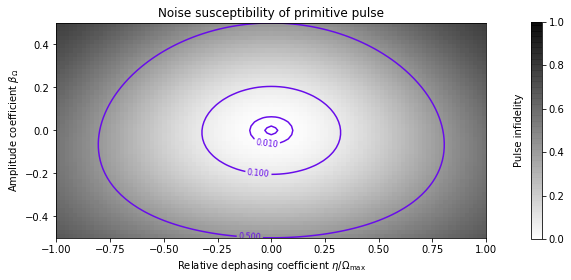

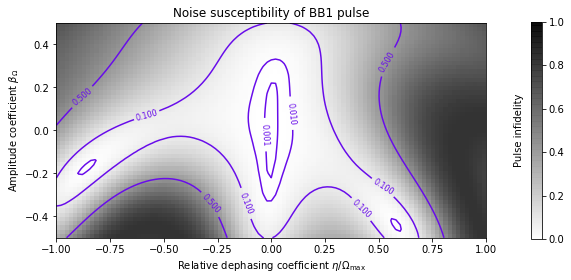

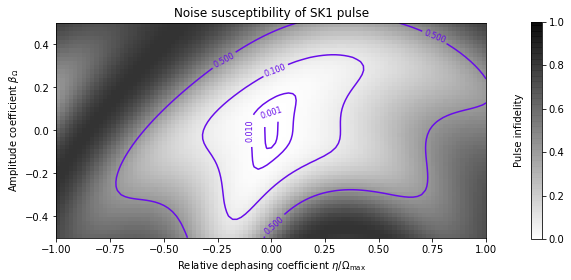

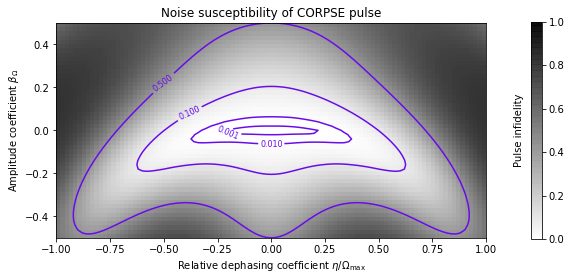

In [6]:
for scheme, scheme_objects in schemes.items():

    fig, ax = plt.subplots(figsize=(10, 4))

    contours = plt.contour(
        scheme_objects["dephasing noise values"] / omega_max,
        scheme_objects["drive noise values"],
        scheme_objects["infidelities"],
        levels=[0.001, 0.01, 0.1, 0.5],
        colors="#680CEA",
    )
    plt.clabel(contours, inline=True, fontsize=8)

    cmap_reversed = plt.cm.get_cmap("gray").reversed()

    plt.imshow(
        scheme_objects["infidelities"],
        extent=[
            np.min(dephasing_coefficients) / omega_max,
            np.max(dephasing_coefficients) / omega_max,
            np.min(amplitude_coefficients),
            np.max(amplitude_coefficients),
        ],
        origin="lower",
        cmap=cmap_reversed,
        alpha=0.8,
        vmin=0,
        vmax=1,
    )

    cbar = plt.colorbar(pad=0.08)
    cbar.set_label("Pulse infidelity", labelpad=-50)
    plt.title("Noise susceptibility of " + scheme + " pulse")
    plt.ylabel(r"Amplitude coefficient $\beta_\Omega$")
    plt.xlabel(r"Relative dephasing coefficient $\eta/\Omega_\mathrm{max}$")
    plt.show()

### Summary

The plots demonstrate clearly the different noise susceptibilities of the different controls. For example, the BB1 control exhibits excellent robustness to amplitude noise (it retains a low infidelity across a wide range of amplitude noise values), but low dephasing robustness (infidelity increases rapidly as the dephasing coefficient varies from zero). The CORPSE control is the opposite: it is robust to dephasing noise, but highly susceptible to amplitude noise.

We have thus demonstrated how the Q-CTRL Python package can be used to characterize the robustness of different controls to quasi-static noise on multiple simultaneous noise channels.

## Example: Susceptibility to dephasing noise

The Q-CTRL Python package may also be used to perform quasi-static scans across a single noise channel. In this example we consider the simple case of a $\pi/2$ pulse performed on a single driven qubit experiencing dephasing noise. The system is described by the Hamiltonian:

\begin{align*}
H(t) = & \frac{\Omega(t)}{2} \sigma_- + \frac{\Omega^*(t)}{2} \sigma_+ + \frac{\Delta(t)}{2}\sigma_z + \frac{\eta(t)}{2} \sigma_z
\end{align*}

where $\Omega(t)$ is a time-dependent Rabi rate, $\Delta(t)$ is a time-dependent clock shift, $\eta(t)$ is a small, slowly-varying stochastic dephasing noise process, $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$, and $\sigma_k$ are the Pauli matrices.

In this case we consider only two driven controls, primitive and CORPSE.

100%|██████████| 100/100 [00:02<00:00, 34.70it/s]


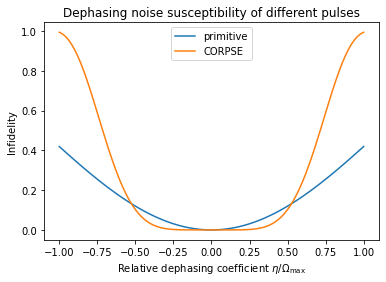

In [7]:
# Define standard matrices
identity = np.array([[1, 0], [0, 1]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)
sigma_m = np.array([[0, 1], [0, 0]], dtype=np.complex)
sqrt_sigma_x = 0.5 * np.array([[1 + 1j, 1 - 1j], [1 - 1j, 1 + 1j]], dtype=np.complex)

# Define control parameters
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi / 2

# Define coefficient array for the noise values
dephasing_coefficients = np.linspace(-1.0, 1.0, 101) * omega_max

# Define the target
target = qctrl.types.TargetInput(
    operator=sqrt_sigma_x,
)

# For each scheme, compute and plot the results of the quasi-static scan
for scheme, function in zip(
    ["primitive", "CORPSE"], [new_primitive_control, new_corpse_control]
):

    # Define pulse objects using pulses from Q-CTRL Open Controls
    pulse = function(
        rabi_rotation=total_rotation,
        azimuthal_angle=0.0,
        maximum_rabi_rate=omega_max,
        name=name,
    )

    # Define Rabi drive term
    rabi_drive = qctrl.types.quasi_static_scan.Drive(
        control=[
            qctrl.types.ComplexSegmentInput(duration=duration, value=value)
            for duration, value in zip(
                pulse.durations, pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles)
            )
        ],
        operator=sigma_m / 2,
    )

    # Define clock shift term
    clock_shift = qctrl.types.quasi_static_scan.Shift(
        control=[
            qctrl.types.RealSegmentInput(duration=duration, value=value)
            for duration, value in zip(pulse.durations, pulse.detunings)
        ],
        operator=sigma_z / 2,
    )

    # Define dephasing drift term
    dephasing_drift = qctrl.types.quasi_static_scan.Drift(
        noise=qctrl.types.quasi_static_scan.Noise(
            name="dephasing noise",
            values=dephasing_coefficients,
        ),
        operator=sigma_z / 2,
    )

    # Define quasi-static function
    quasi_static_scan_result = qctrl.functions.calculate_quasi_static_scan(
        duration=pulse.duration,
        drives=[rabi_drive],
        shifts=[clock_shift],
        drifts=[dephasing_drift],
        target=target,
    )

    # Extract infidelities and noise values
    infidelities = np.array(
        [sample.infidelity for sample in quasi_static_scan_result.samples]
    )
    noise_values = np.array(
        [sample.noise_values[0].value for sample in quasi_static_scan_result.samples]
    )

    # Plot infidelities
    plt.plot(noise_values / omega_max, infidelities, label=scheme)


plt.title("Dephasing noise susceptibility of different pulses")
plt.ylabel("Infidelity")
plt.xlabel(r"Relative dephasing coefficient $\eta/\Omega_\mathrm{max}$")
plt.legend()
plt.show()